In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import random
import math

from tensorflow import keras

import tensorflow_datasets as tfds
from pathlib import Path


2022-05-26 20:39:33.473914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 20:39:33.473970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tatsuyafukui/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)



In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path)
                     for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path)
                    for path in quickdraw_dir.glob("eval.tfrecord-*")])


In [4]:
train_files


['/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files


['/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/tatsuyafukui/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()


In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]


In [8]:
sorted(class_names)


['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [20]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    print(data_batch)
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels


In [21]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)


In [22]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])


Tensor("args_0:0", shape=(None,), dtype=string)
Tensor("args_0:0", shape=(None,), dtype=string)
Tensor("args_0:0", shape=(None,), dtype=string)


In [12]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)


sketches = tf.Tensor(
[[[-0.02352941  0.04458597  0.        ]
  [-0.00392157  0.05732483  0.        ]
  [ 0.01568627  0.05732489  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.06274509 -0.09958507  0.        ]
  [ 0.07450981 -0.04149377  0.        ]
  [ 0.09411764 -0.02074689  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.29019606  0.07798167  0.        ]
  [ 0.18823531  0.01376146  0.        ]
  [ 0.10980392 -0.0321101   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.9752066   0.05681819  0.        ]
  [ 0.         -0.13636363  0.        ]
  [-0.04958677 -0.14772728  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

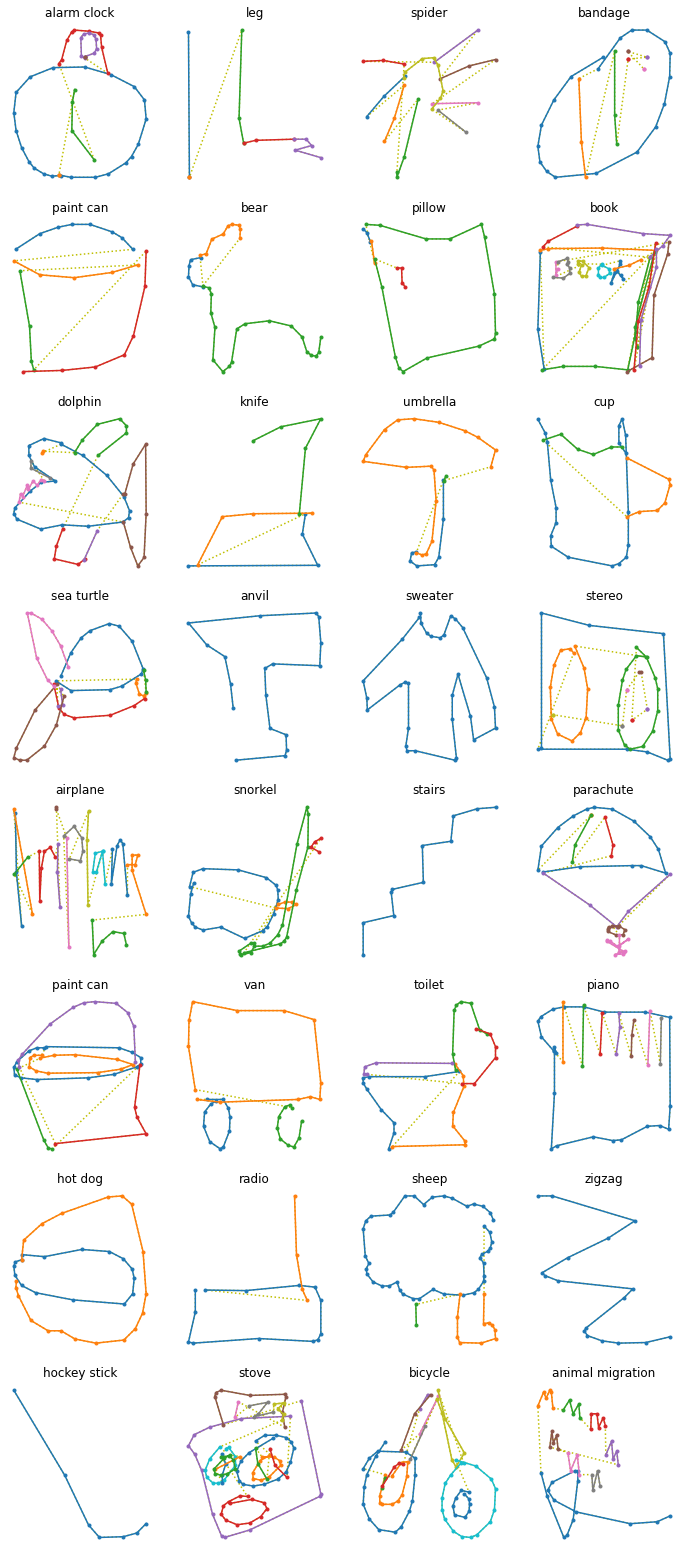

In [13]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")


def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()


for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)


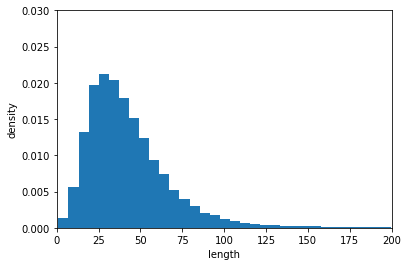

In [14]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()


In [15]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))


cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)


In [23]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)


Epoch 1/2
  40432/Unknown - 1955s 48ms/step - loss: 5.0339 - accuracy: 0.0526 - sparse_top_k_categorical_accuracy: 0.1585

KeyboardInterrupt: 